<a href="https://colab.research.google.com/github/jmhuer/Fall2021MusicResearch/blob/main/Fall2021MusicResearch/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usage Demo : 


In [22]:
# !rm -r python3_midi/
!sudo apt-get install libasound2-dev swig
# !pip3 install git+https://github.com/vishnubob/python-midi@feature/python3
!pip3 install git+https://github.com/vishnubob/python-midi@feature/python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (848 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: 

In [2]:
# !unzip /content/reconstruction.zip

Archive:  /content/reconstruction.zip
replace reconstruction/AERECUNSTRUCTION&O2.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!git clone https://github.com/gregwinther/mgeval

fatal: destination path 'mgeval' already exists and is not an empty directory.


In [81]:
import midi
import glob
import numpy as np
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
from mgeval.mgeval import core, utils
from sklearn.model_selection import LeaveOneOut

## Absolute measurement: statistic analysis


Assign dataset path

In [82]:
set1 = glob.glob('/content/original/*.mid')

construct empty dictionary to fill in measurement across samples

In [83]:
num_samples = len(set1)
print(num_samples)

4


In [84]:
set1_eval = {'total_used_pitch':np.zeros((num_samples,1))}
metrics_list = list(set1_eval.keys())
for i in range(0, num_samples):
    feature = core.extract_feature(set1[i])
    set1_eval[metrics_list[0]][i] = getattr(core.metrics(), metrics_list[0])(feature)

repeat for second dataset

In [85]:
set2 = glob.glob('/content/reconstruction/*.mid')
set2_eval = {'total_used_pitch':np.zeros((num_samples,1))}
for i in range(0, num_samples):
    feature = core.extract_feature(set2[i])
    set2_eval[metrics_list[0]][i] = getattr(core.metrics(), metrics_list[0])(feature)

statistic analysis: absolute measurement

In [86]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(set1_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(set1_eval[metrics_list[i]], axis=0))

    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(set2_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(set2_eval[metrics_list[i]], axis=0))


total_used_pitch:
------------------------
 demo_set
  mean:  [31.75]
  std:  [1.08972474]
------------------------
 demo_set
  mean:  [37.25]
  std:  [3.69966215]


## Relative measurement: generalizes the result among features with various dimensions


the features are sum- marized to 
- the intra-set distances
- the difference of intra-set and inter-set distances.

exhaustive cross-validation for intra-set distances measurement

In [87]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
set1_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
set2_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        set1_intra[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set1_eval[metrics_list[i]][train_index])
        set2_intra[test_index[0]][i] = utils.c_dist(set2_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]][train_index])


exhaustive cross-validation for inter-set distances measurement

In [88]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]])

visualization of intra-set and inter-set distances

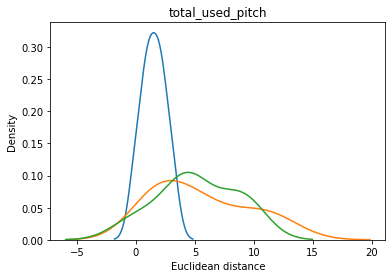

In [89]:
plot_set1_intra = np.transpose(set1_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_set2_intra = np.transpose(set2_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_set1_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_set2_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

the difference of intra-set and inter-set distances.

In [90]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set1')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_set1_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_set1_intra[i], plot_sets_inter[i]))
    
    print(' demo_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_set2_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_set2_intra[i], plot_sets_inter[i]))
    

total_used_pitch:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.054084494055167354
  Overlap area: 0.32133607570692835
 demo_set2
  Kullback–Leibler divergence: 0.08738055631882163
  Overlap area: 0.761118395737127
